# Setup

In [22]:
%load_ext autoreload
%autoreload 2
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [23]:
%matplotlib inline

In [24]:
from relaxed.plot_defaults import *

In [25]:
import astropy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
import re 
from astropy.table import Table
import astropy.table
import json
from scipy import stats
from copy import deepcopy
import scipy
import warnings
from tqdm import tqdm

import matplotlib as mpl
from sklearn.model_selection import train_test_split


In [31]:
from relaxed.analysis import get_mah, add_box_indices, get_tt_indices, alpha_analysis
from relaxed.models import training_suite
from relaxed import halo_catalogs


# Data

In [27]:
mah_data = get_mah('m12', '../../output/', cutoff_missing=0.05, cutoff_particle=0.05)

In [28]:
# catalog
cat = mah_data['cat']
xoff = cat['x0']
cvir = cat['cvir']
eta = cat['eta']
spin = cat['spin']
voff = cat['v0']
# spin_b = cat['spin_bullock'] # need to add catalog 
# m2 = cat['m2_a179'], fraction of largest subhalo mass 
# separate b/a and c/a ?? 
q = cat['q']
ma = mah_data['ma']
am = mah_data['am']

scales = mah_data['scales']
mass_bins = mah_data['mass_bins']
print(cvir.shape, xoff.shape, eta.shape, am.shape, ma.shape, scales.shape, mass_bins.shape)

add_box_indices(cat)

(10000,) (10000,) (10000,) (10000, 100) (10000, 165) (165,) (100,)


In [32]:
alphas, ma_exp, am_exp = alpha_analysis(ma, scales, mass_bins)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:23<00:00, 119.39it/s]


In [48]:
# train/test split
train_idx, test_idx = get_tt_indices(len(cat), test_ratio=0.33)
cat_train, am_train, cvir_train, xoff_train, eta_train, voff_train, q_train, spin_train, alpha_train = (cat[train_idx], am[train_idx], cvir[train_idx], 
                                                           xoff[train_idx], eta[train_idx], voff[train_idx], q[train_idx], spin[train_idx], alphas[train_idx])
cat_test, am_test, cvir_test, xoff_test, eta_test, voff_test, q_test, spin_test, alpha_test = (cat[test_idx], am[test_idx], cvir[test_idx], 
                                                     xoff[test_idx], eta[test_idx], voff[test_idx], q[test_idx], spin[test_idx], alphas[test_idx])
print(cvir_train.shape, cvir_test.shape, alpha_train.shape)

(6700,) (3300,) (6700, 1)


# Train

In [49]:
# all cvir models are specified in data.
data = {
    'cam_1/2': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.50, 'cam_order': -1}},
    'linear': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'linear_alpha': {
        'xy': (alpha_train, cvir_train), 'n_features': 1, 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'linear_marginal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {'to_marginal_normal':True, 'use_multicam':False}},
    'lognormal': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, cvir_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
cvir_models = training_suite(data)

# eta
data = {
    'cam_1/2': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, eta_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {},
    },
}

eta_models = training_suite(data)

# xoff
data = {
    'cam_1/2': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.5, 'cam_order': +1}},
    'cam_peak': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'cam',
        'kwargs': {'mass_bins': mass_bins, 'mbin': 0.738, 'cam_order': +1}},
    'linear': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'linear',
        'kwargs': {}},
    'lognormal': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'lognormal', 'kwargs': {}
    },
    'gaussian': {
        'xy': (am_train, xoff_train), 'n_features': am_train.shape[1], 'n_targets': 1, 'model': 'gaussian', 
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    },
}
xoff_models = training_suite(data)

# joint models
y_train = np.hstack([cvir_train.reshape(-1, 1), eta_train.reshape(-1, 1), xoff_train.reshape(-1, 1), 
                     spin_train.reshape(-1, 1), q_train.reshape(-1, 1)])
data ={
    'multi_gaussian': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 5, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 
    'multi_gaussian_alpha': {
        'xy': (alpha_train, y_train), 'n_features': 1, 'n_targets': 5, 'model': 'gaussian',
        'kwargs': {'to_marginal_normal':True , 'use_multicam': True},
    }, 
    'lognormal': {
        'xy': (am_train, y_train), 'n_features': am_train.shape[1], 'n_targets': 5, 'model': 'lognormal', 'kwargs': {}
    },
}
joint_models = training_suite(data)

# Triangle plot 

In [50]:
import corner
from sklearn.preprocessing import QuantileTransformer
from scipy import stats


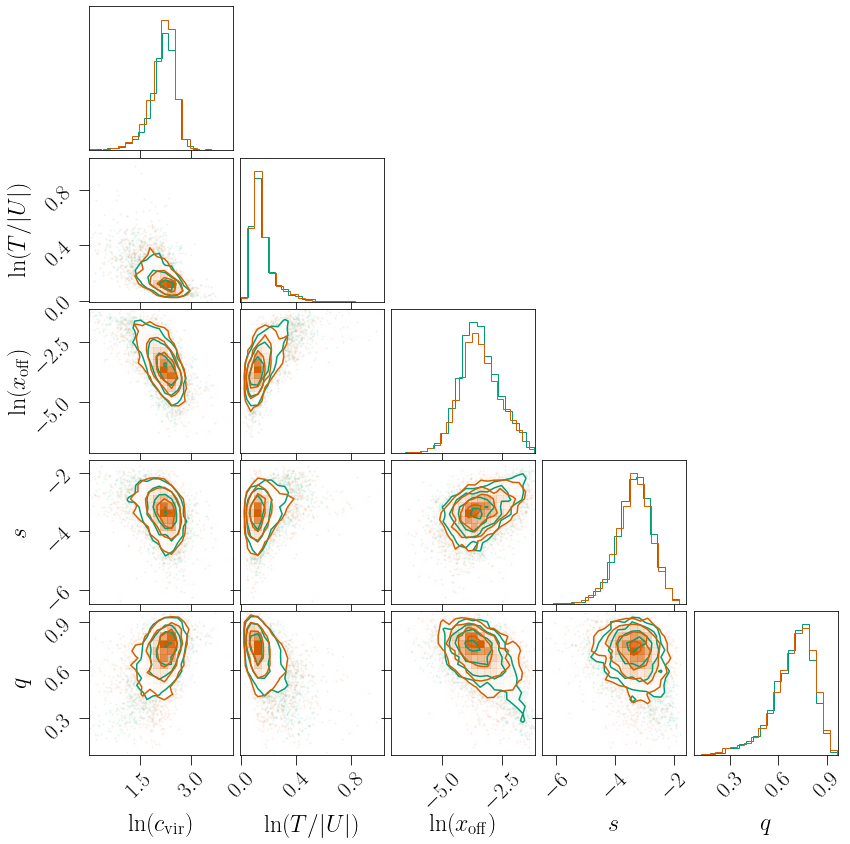

In [51]:
# multi-gaussian approach should do the best.
model = joint_models['multi_gaussian']
y_samples = model.sample(am_test, 1).reshape(-1, 5)
y_true = np.hstack([cvir_test.reshape(-1, 1), eta_test.reshape(-1, 1), xoff_test.reshape(-1, 1), spin_test.reshape(-1, 1),
                   q_test.reshape(-1, 1)])

# quantile transform each for plotting purposes (basically mean centering)
y1 = np.hstack([np.log(y_true[:, :4]), y_true[:, 4].reshape(-1, 1)])
y2 = np.hstack([np.log(y_samples[:, :4]), y_samples[:, 4].reshape(-1, 1)])


labels = ['$\\ln(c_{\\rm vir})$', '$\\ln(T / |U|)$', '$\\ln(x_{\\rm off})$', '$s$', '$q$']
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples

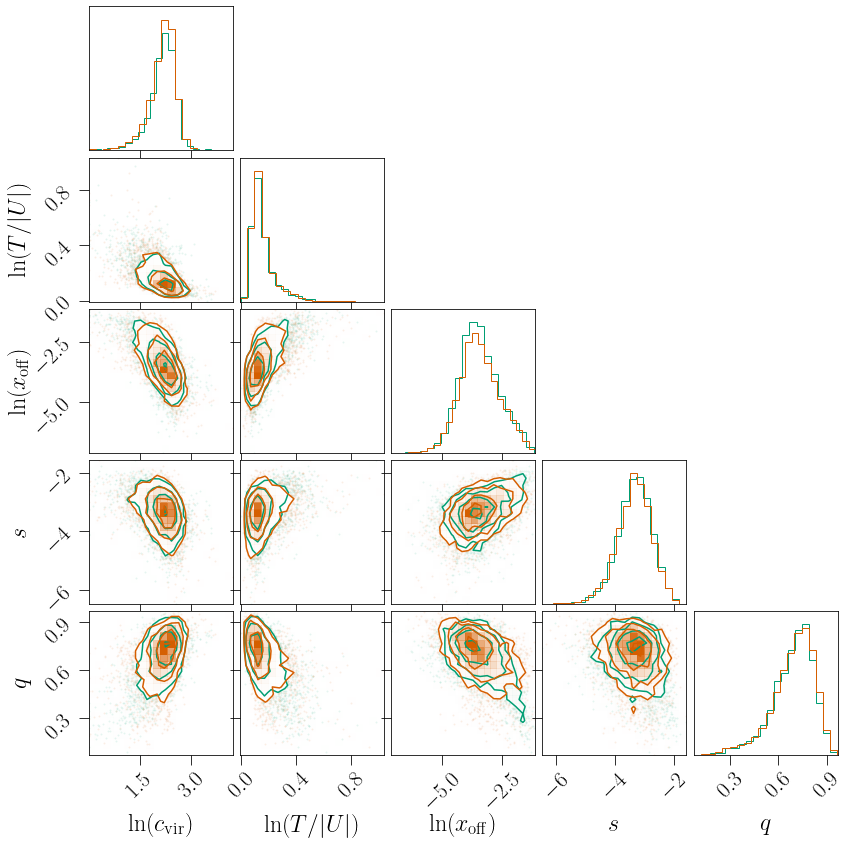

In [52]:
# multi-gaussian w/ only alpha (should be the same as above since sample from posterior)
model = joint_models['multi_gaussian_alpha']
y_samples = model.sample(alpha_test, 1).reshape(-1, 5)
y_true = np.hstack([cvir_test.reshape(-1, 1), eta_test.reshape(-1, 1), xoff_test.reshape(-1, 1), spin_test.reshape(-1, 1),
                   q_test.reshape(-1, 1)])

# quantile transform each for plotting purposes (basically mean centering)
y1 = np.hstack([np.log(y_true[:, :4]), y_true[:, 4].reshape(-1, 1)])
y2 = np.hstack([np.log(y_samples[:, :4]), y_samples[:, 4].reshape(-1, 1)])


labels = ['$\\ln(c_{\\rm vir})$', '$\\ln(T / |U|)$', '$\\ln(x_{\\rm off})$', '$s$', '$q$']
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1', labelpad=0.1) # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2', labelpad=0.1) # orange = samples

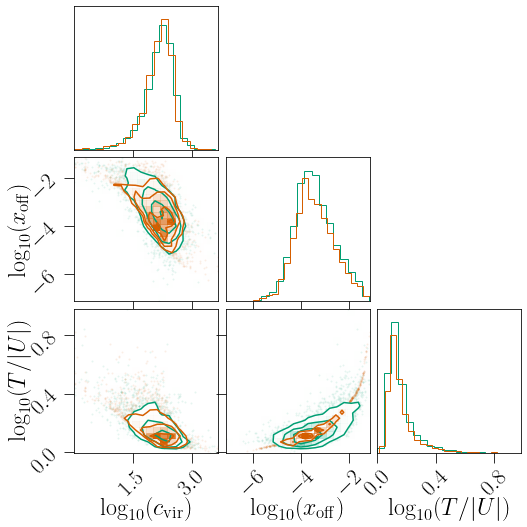

In [53]:
# CAM does not get correlations right
y_true = np.hstack([cvir_test.reshape(-1, 1), xoff_test.reshape(-1, 1), eta_test.reshape(-1, 1)])

models = (cvir_models['cam_1/2'], xoff_models['cam_peak'], eta_models['cam_peak'])
y_samples =np.hstack([models[0].predict(am_test), models[1].predict(am_test),  models[2].predict(am_test)])

# quantile transform each for plotting purposes (basically mean centering)
y1 = np.log(y_true)
y2 = np.log(y_samples)

labels = ['$\\log_{10}(c_{\\rm vir})$', '$\\log_{10}(x_{\\rm off})$', '$\\log_{10}(T / |U|)$']# fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1') # green = true
fig = corner.corner(y1, labels=labels, max_n_ticks=3, color='C1') # green = true
fig = corner.corner(y2, labels=labels, max_n_ticks=3, fig=fig, color='C2' ) # orange = samples
